# Задача 4. Многоклассовая классификация и множественная классификация/регрессия

* **Дедлайн**: 13.12.2024, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [ ] Изучите [возможности sklearn](https://scikit-learn.org/stable/modules/multiclass.html#multiclass-classification) для решения задач **Multiclass classification**, **Multilabel classification** и **Multioutput Regression**. Основные компоненты библиотеки указаны на рисунке ниже.
![multi_org_chart](https://scikit-learn.org/stable/_images/multi_org_chart.png)

- [ ] Найдите данные, на которых можно решить задачу **Multiclass classification** (классификация с более чем двумя классами). В крайнем случае преобразуйте данные, предназначенные для другой задачи.
- [ ] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи.
- [ ] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [ ] Используя стратегии **OneVsRest**, **OneVsOne** и **OutputCode** решите задачу **Multiclass classification** для каждого из пройденных базового алгоритма классификации (**logistic regression, svm, knn, naive bayes, decision tree**). При обучении использовать **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания.
- [ ] Замерить время обучения каждой модели для каждой стратегии.
- [ ] Для оценки качества моделей используйте метрику **AUC-ROC**.
- [ ] Сравнить время обучения и качество всех моделей и всех стратегий. Сделать выводы.
- [ ] * (**+3 балла**) Повторить все пункты для задачи **Multilabel classification** (классификация с несколькими целевыми признаками, например, бинарными). В качестве стратегий попробовать **MultiOutputClassifier** и **ClassifierChain**.
- [ ] * (**+2 балла**) Повторить все пункты для задачи **Multioutput Regression** (регрессия с несколькими целевыми признаками, вещественными). Модель попробовать как минимум одну: **Ridge**. В качестве стратегий попробовать **MultiOutputRegressor** и **RegressorChain**. В качестве метрики использовать **R2**.


In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier



sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore') 

Размерность данных: (1797, 64)
Количество классов: 10
Классы: [0 1 2 3 4 5 6 7 8 9]


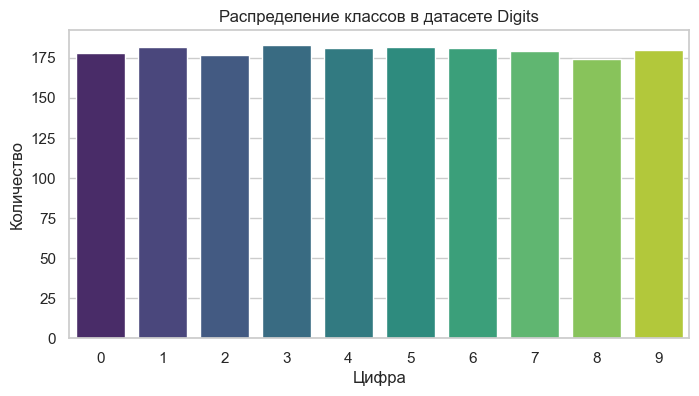

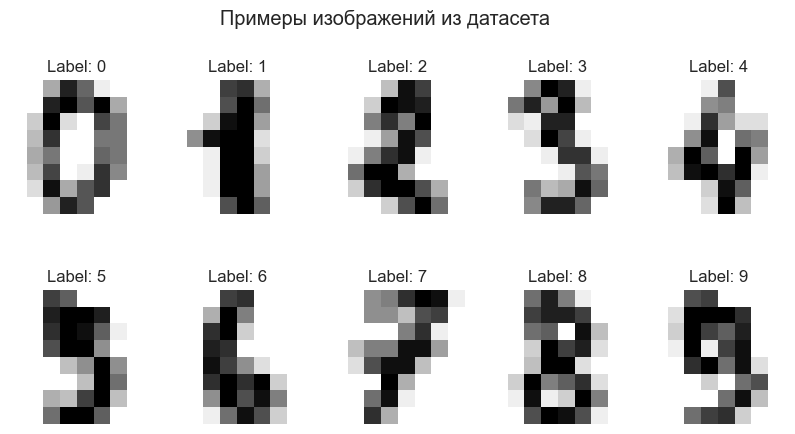

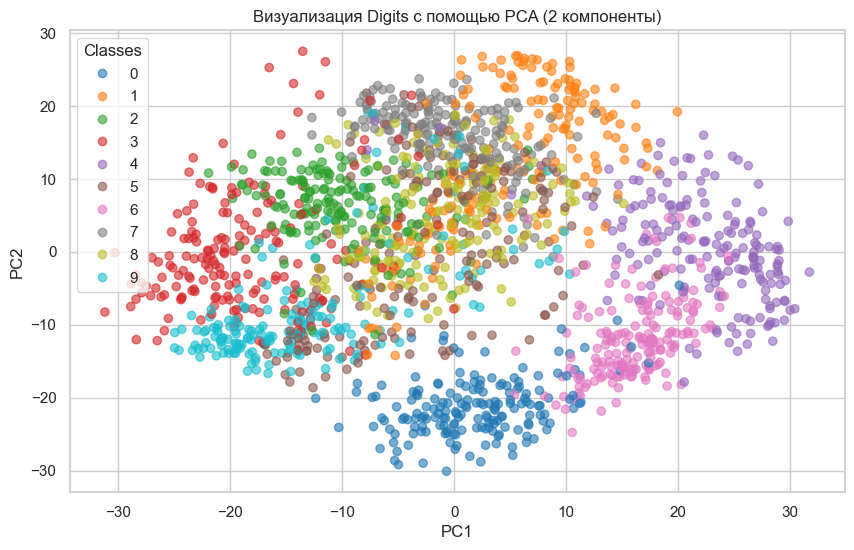

In [ ]:
from sklearn.datasets import load_digits, make_multilabel_classification
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, r2_score, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


digits = load_digits()
X_mc, y_mc = digits.data, digits.target

print(f"Размерность данных: {X_mc.shape}")
print(f"Количество классов: {len(np.unique(y_mc))}")
print(f"Классы: {np.unique(y_mc)}")

# EDA: Распределение классов
plt.figure(figsize=(8, 4))
sns.countplot(x=y_mc, palette="viridis")
plt.title("Распределение классов в датасете Digits")
plt.xlabel("Цифра")
plt.ylabel("Количество")
plt.show()
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary')
    ax.set_title(f"Label: {digits.target[i]}")
    ax.axis('off')
plt.suptitle("Примеры изображений из датасета")
plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_mc)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_mc, cmap='tab10', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("Визуализация Digits с помощью PCA (2 компоненты)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [ ]:
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
    X_mc, y_mc, test_size=0.3, random_state=42, stratify=y_mc
)


## Мультикласс

In [5]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier, OutputCodeClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain, MultiOutputRegressor, RegressorChain

base_models = {
    'LogReg': LogisticRegression(max_iter=1000, solver='liblinear'),
    'SVM': SVC(probability=True, kernel='rbf'), 
    'KNN': KNeighborsClassifier(),
    'NaiveBayes': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

param_grids = {
    'LogReg': {'model__estimator__C': [0.1, 1, 10]},
    'SVM': {'model__estimator__C': [0.1, 1, 10], 'model__estimator__gamma': ['scale', 'auto']},
    'KNN': {'model__estimator__n_neighbors': [3, 5, 7]},
    'NaiveBayes': {'model__estimator__var_smoothing': [1e-9, 1e-8]}, 
    'DecisionTree': {'model__estimator__max_depth': [None, 5, 10]}
}


strategies = {
    'OneVsRest': OneVsRestClassifier,
    'OneVsOne': OneVsOneClassifier,
    'OutputCode': OutputCodeClassifier 
}

results_mc = []

for strat_name, StratClass in strategies.items():
    for model_name, model_inst in base_models.items():
        print(f"Processing: {strat_name} + {model_name}")
        
        if strat_name == 'OutputCode':
            classifier = StratClass(estimator=model_inst, random_state=42)
        else:
            classifier = StratClass(estimator=model_inst)
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', classifier)
        ])
        
        grid = param_grids[model_name]
        start_time = time.time()
        
        gs = GridSearchCV(pipeline, grid, cv=3, scoring='accuracy', n_jobs=-1)
        gs.fit(X_train_mc, y_train_mc)
        
        train_time = time.time() - start_time
        best_model = gs.best_estimator_
        
        try:
            if hasattr(best_model, "predict_proba"):
                y_prob = best_model.predict_proba(X_test_mc)
                roc_auc = roc_auc_score(y_test_mc, y_prob, multi_class='ovr', average='macro')
            elif hasattr(best_model, "decision_function"):
                y_prob = best_model.decision_function(X_test_mc)
                if strat_name == 'OneVsOne' and model_name == 'SVM':
                     roc_auc = np.nan
                else:
                     roc_auc = np.nan
            else:
                roc_auc = np.nan
        except Exception as e:
            roc_auc = np.nan
            
        acc = accuracy_score(y_test_mc, best_model.predict(X_test_mc))
        results_mc.append({
            'Strategy': strat_name,
            'Model': model_name,
            'Time (s)': train_time,
            'ROC-AUC': roc_auc if not np.isnan(roc_auc) else acc, # Если ROC нет, пишем Accuracy и пометим это
            'Metric Type': 'ROC-AUC' if not np.isnan(roc_auc) else 'Accuracy',
            'Best Params': gs.best_params_
        })

Processing: OneVsRest + LogReg
Processing: OneVsRest + SVM
Processing: OneVsRest + KNN
Processing: OneVsRest + NaiveBayes
Processing: OneVsRest + DecisionTree
Processing: OneVsOne + LogReg
Processing: OneVsOne + SVM
Processing: OneVsOne + KNN
Processing: OneVsOne + NaiveBayes
Processing: OneVsOne + DecisionTree
Processing: OutputCode + LogReg
Processing: OutputCode + SVM
Processing: OutputCode + KNN
Processing: OutputCode + NaiveBayes
Processing: OutputCode + DecisionTree


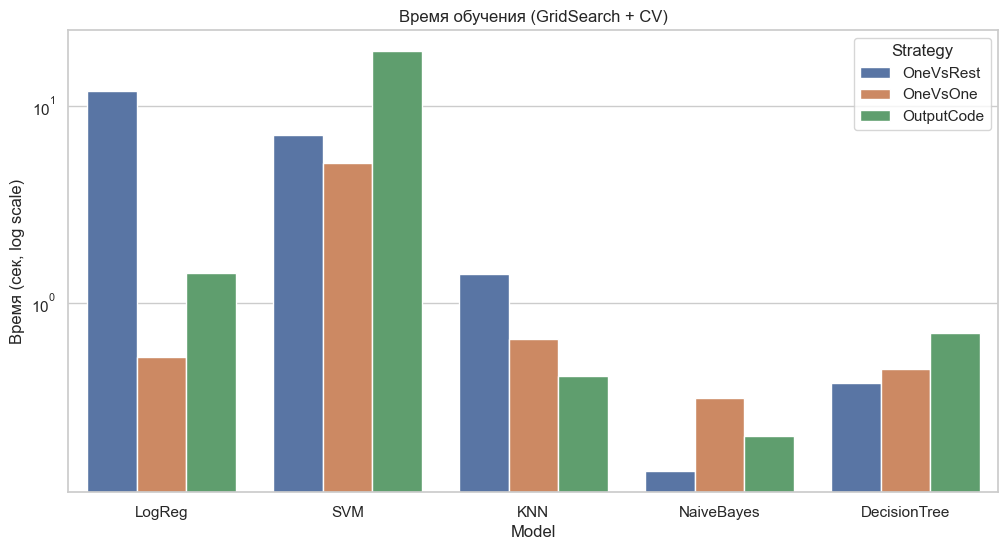

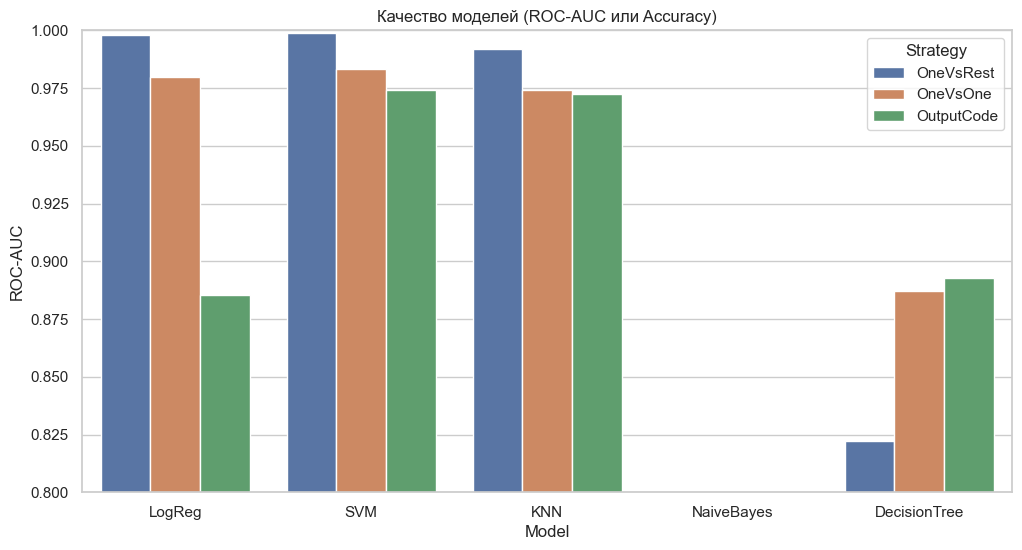

,Strategy,Model,Time (s),ROC-AUC,Metric Type,Best Params
1,OneVsRest,SVM,7.132819,0.998819,ROC-AUC,"{'model__estimator__C': 10, 'model__estimator_..."
0,OneVsRest,LogReg,11.828636,0.997869,ROC-AUC,{'model__estimator__C': 1}
2,OneVsRest,KNN,1.404417,0.991713,ROC-AUC,{'model__estimator__n_neighbors': 3}
6,OneVsOne,SVM,5.096351,0.983333,Accuracy,"{'model__estimator__C': 10, 'model__estimator_..."
5,OneVsOne,LogReg,0.531959,0.979630,Accuracy,{'model__estimator__C': 1}
11,OutputCode,SVM,18.877698,0.974074,Accuracy,"{'model__estimator__C': 10, 'model__estimator_..."
7,OneVsOne,KNN,0.660460,0.974074,Accuracy,{'model__estimator__n_neighbors': 3}
12,OutputCode,KNN,0.427859,0.972222,Accuracy,{'model__estimator__n_neighbors': 3}
14,OutputCode,DecisionTree,0.702701,0.892593,Accuracy,{'model__estimator__max_depth': None}
9,OneVsOne,DecisionTree,0.464594,0.887037,Accuracy,{'model__estimator__max_depth': None}


In [6]:
df_results_mc = pd.DataFrame(results_mc)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_results_mc, x='Model', y='Time (s)', hue='Strategy')
plt.title("Время обучения (GridSearch + CV)")
plt.yscale('log')
plt.ylabel("Время (сек, log scale)")
plt.show()

# Визуализация качества
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results_mc, x='Model', y='ROC-AUC', hue='Strategy')
plt.title("Качество моделей (ROC-AUC или Accuracy)")
plt.ylim(0.8, 1.0)
plt.show()

display(df_results_mc.sort_values(by='ROC-AUC', ascending=False))

Видно что наивный байес - rip, пиксели 100% связанны
svm и knn показали хороший результат


## Мультилэйбл

Размерность X: (1000, 20), y: (1000, 5)
Пример меток (первые 5):
[[0 0 0 1 0]
 [1 1 1 0 0]
 [0 0 1 1 0]
 [1 0 0 0 0]
 [1 0 1 0 0]]


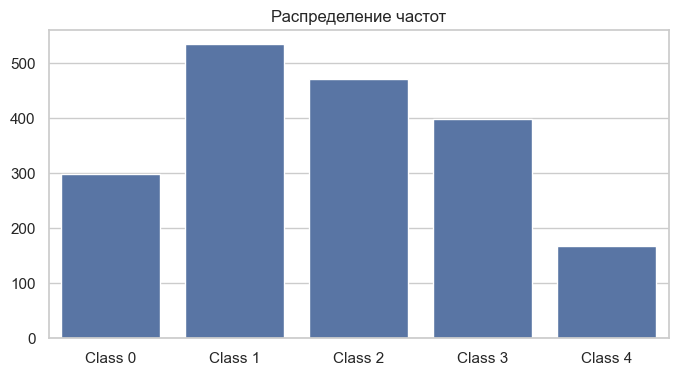

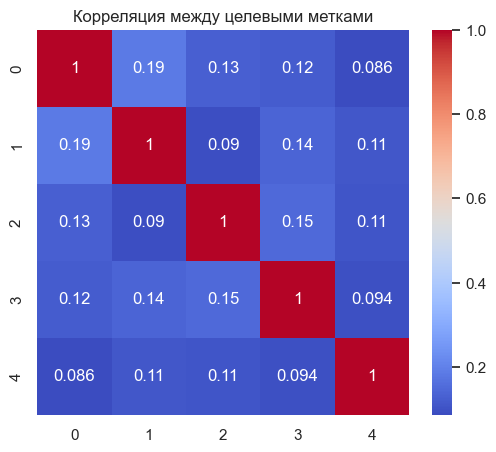

In [8]:
X_ml, y_ml = make_multilabel_classification(
    n_samples=1000, n_features=20, n_classes=5, n_labels=2, random_state=42
)

print(f"Размерность X: {X_ml.shape}, y: {y_ml.shape}")
print("Пример меток (первые 5):")
print(y_ml[:5])

label_counts = np.sum(y_ml, axis=0)
plt.figure(figsize=(8, 4))
sns.barplot(x=[f"Class {i}" for i in range(5)], y=label_counts)
plt.title("Распределение частот")
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(pd.DataFrame(y_ml).corr(), annot=True, cmap='coolwarm')
plt.title("Корреляция между целевыми метками")
plt.show()

In [10]:
X_ml

array([[3., 0., 2., ..., 5., 0., 2.],
       [3., 5., 2., ..., 6., 2., 0.],
       [3., 2., 3., ..., 6., 3., 3.],
       ...,
       [3., 2., 3., ..., 2., 2., 2.],
       [3., 0., 0., ..., 1., 3., 3.],
       [2., 2., 4., ..., 2., 1., 2.]], shape=(1000, 20))

In [11]:
from sklearn.ensemble import RandomForestClassifier

X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size=0.3, random_state=42)
ml_models = {
    'LogReg': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=50, random_state=42)
}
ml_strategies = {
    'MultiOutput': MultiOutputClassifier,
    'Chain': ClassifierChain
}
results_ml = []

for strat_name, StratClass in ml_strategies.items():
    for model_name, model_inst in ml_models.items():
        classifier = StratClass(estimator=model_inst)
        
        start_time = time.time()
        classifier.fit(X_train_ml, y_train_ml)
        fit_time = time.time() - start_time
        y_pred = classifier.predict(X_test_ml)
        
        try:
            score = roc_auc_score(y_test_ml, y_pred, average='macro')
        except ValueError:
            score = 0
            
        results_ml.append({
            'Strategy': strat_name,
            'Model': model_name,
            'Time': fit_time,
            'ROC-AUC (macro)': score
        })

df_results_ml = pd.DataFrame(results_ml)
display(df_results_ml)

,Strategy,Model,Time,ROC-AUC (macro)
0,MultiOutput,LogReg,0.158395,0.759313
1,MultiOutput,RandomForest,0.533196,0.732011
2,Chain,LogReg,0.058039,0.743607
3,Chain,RandomForest,0.600491,0.730525


## Multi Output Regression

Features: ['Chins', 'Situps', 'Jumps']
Targets: ['Weight', 'Waist', 'Pulse']


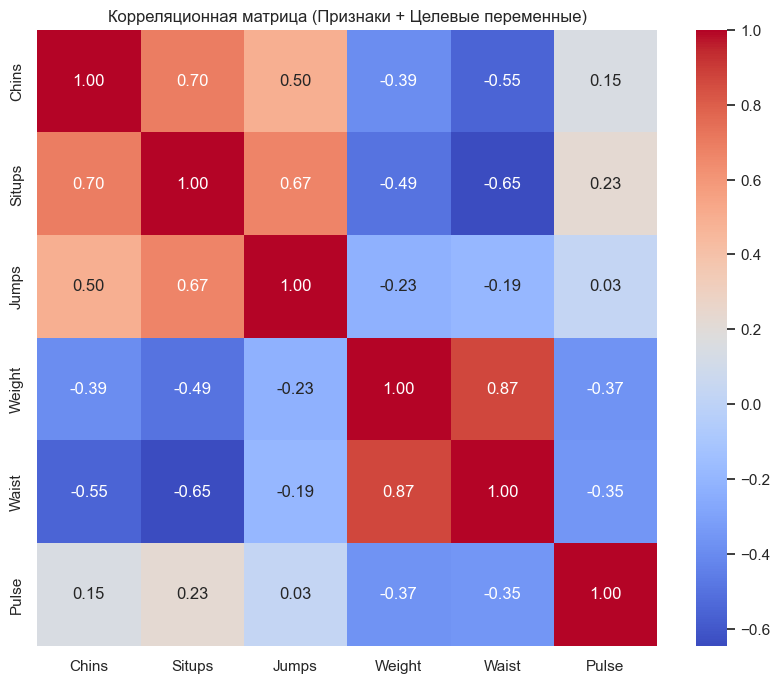

In [ ]:
from sklearn.datasets import load_linnerud
    
linnerrud = load_linnerud()
X_mr, y_mr = linnerrud.data, linnerrud.target
feature_names = linnerrud.feature_names
target_names = linnerrud.target_names

print(f"Features: {feature_names}")
print(f"Targets: {target_names}")

data_mr = np.hstack([X_mr, y_mr])
df_mr = pd.DataFrame(data_mr, columns=feature_names + target_names)

plt.figure(figsize=(10, 8))
sns.heatmap(df_mr.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Корреляционная матрица (Признаки + Целевые переменные)")
plt.show()

In [ ]:
from sklearn.linear_model import Ridge

X_train_mr, X_test_mr, y_train_mr, y_test_mr = train_test_split(X_mr, y_mr, test_size=0.2, random_state=42)

scaler_x = StandardScaler()
X_train_mr_sc = scaler_x.fit_transform(X_train_mr)
X_test_mr_sc = scaler_x.transform(X_test_mr)


mr_strategies = {
    'MultiOutput': MultiOutputRegressor,
    'Chain': RegressorChain
}

results_mr = []
base_regressor = Ridge(alpha=1.0)

for strat_name, StratClass in mr_strategies.items():
    regressor = StratClass(estimator=base_regressor)
    start_time = time.time()
    regressor.fit(X_train_mr_sc, y_train_mr)
    fit_time = time.time() - start_time
    y_pred = regressor.predict(X_test_mr_sc)
    r2 = r2_score(y_test_mr, y_pred, multioutput='uniform_average')
    
    results_mr.append({
        'Strategy': strat_name,
        'Model': 'Ridge',
        'Time': fit_time,
        'R2 Score': r2
    })

df_results_mr = pd.DataFrame(results_mr)
display(df_results_mr)

,Strategy,Model,Time,R2 Score
0,MultiOutput,Ridge,0.16023,-0.890153
1,Chain,Ridge,0.00000,-0.890153
